Este Notebook contiene una implementación de un proceso para facilitar la identificación de PID.  

In [1]:
import numpy as np
import cv2 as cv
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

from ipywidgets import interactive, widgets, Layout

%matplotlib inline 
# se importa el modulo de vision
from pv_vision.transform_crop.solarmodule import MaskModule

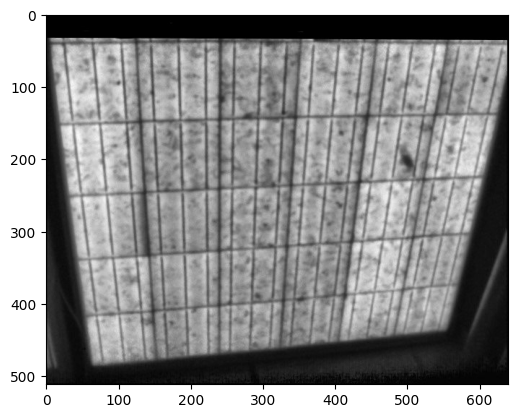

In [2]:
img = cv.imread(
'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Datasets_EL/Modulos/poli2_inf_edited.jpg', 0)
#D:\Documentos\Universidad de Cuenca\Trabajo de Titulación\Datasets_EL\Modulos\poli1_sup.jpg
save_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Datasets_EL/ModulosPID'
module_name = 'poli2_inf_PID'

raw_module = MaskModule(img, 5, 6, 3) # 5 filas, 6 columnas, 3 busbar
#rotated_module = raw_module.rotate(0)
plt.imshow(raw_module.image, 'gray')
#plt.imshow(rotated_module, 'gray')

In [3]:
## Carga la mascara de la imagen
## Se usa el deslizador para encontrar el umbral adecuado
def update_mask(thre):
    mask = raw_module.load_mask(thre=thre, output=True)
    plt.figure(figsize=(8, 6))
    #plt.imshow(mask, "gray")
    mask_array = np.array(raw_module.mask)
    plt.imshow(mask_array, 'gray')

thre = widgets.FloatSlider(value=0.28, min=0, max=1, step=0.02)
interactive(update_mask,
            thre=thre, description="Threshold")

interactive(children=(FloatSlider(value=0.28, description='thre', max=1.0, step=0.02), Output()), _dom_classes…

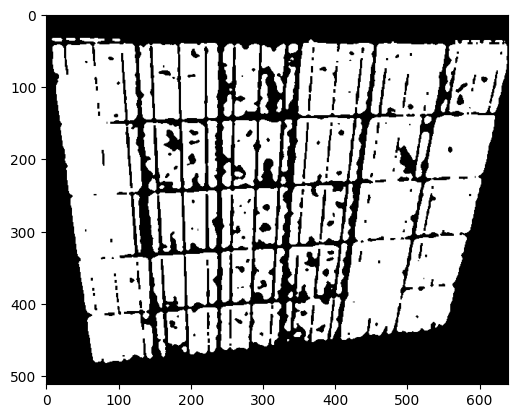

In [8]:
## Carga la mascara de la imagen con el umbral establecido
thre.value

# Se almacenara la mascara en una instancia raw_module
#plt.imshow(raw_module.mask, "gray")
mask_array = np.array(raw_module.mask)
plt.imshow(mask_array, 'gray')

In [9]:
# Detección de esquinas
# Se usa el deslizador para encontrar el mejor modo de detección de esquinas

def update_corner(mode):
    corners = raw_module.corner_detection_cont(output=True, mode=mode)
    x, y = zip(*corners)

    mask_array = np.array(raw_module.mask)
    plt.imshow(mask_array, 'gray')
    plt.scatter(x, y, c='r')

mode=widgets.IntSlider(value=0, min=0, max=4, step=1)
interactive(update_corner,
            mode=mode)

interactive(children=(IntSlider(value=0, description='mode', max=4), Output()), _dom_classes=('widget-interact…

Módulo transformado con éxito
Dimensiones del módulo:  (1550, 1860)


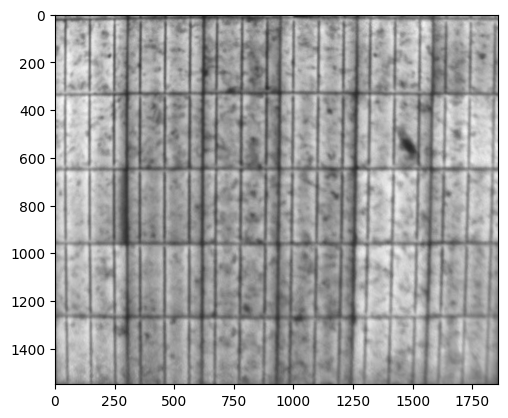

In [11]:
# Transformación de módulos

#img_transformed = raw_module.transform(cellsize=30, img_only=True) #30W
img_transformed = raw_module.transform(cellsize=310, auto_rotate=True, img_only=True)  # 300 para resize IA #250
if isinstance(img_transformed, np.ndarray):
    print("Módulo transformado con éxito")
    plt.imshow(img_transformed, 'gray')


# Imprime el tamaño del módulo
print("Dimensiones del módulo: ", img_transformed.shape)

In [12]:
# Ajuste de parámetros para bordes verticales

def update_edges(vl_split_size, vl_interval, vl_margin, vl_thre):
    fig = plt.figure(figsize=(8, 6))
    raw_module.plot_peaks(n_list=[2, 5, 6], split_size=vl_split_size,
                          interval=vl_interval, margin=vl_margin, thre=vl_thre, direction=0)

inner_edges_para = {
    'vl_interval': widgets.IntText(value=130),  # 239 para resize IA
    'vl_thre': widgets.FloatText(value=0.9),    # 0.9 para resize IA
    'vl_split_size': widgets.IntText(value=70), # 90 para resize IA, 30 Mono
    'vl_margin': widgets.IntText(value=140)     # 200 para resize IA, 120 Mono
}

interactive(update_edges, **inner_edges_para)

interactive(children=(IntText(value=70, description='vl_split_size'), IntText(value=130, description='vl_inter…

<Figure size 800x600 with 0 Axes>

In [13]:
# Ajuste de parámetros para bordes horizontales

def update_edges(hl_split_size, hl_interval, hl_margin, hl_thre):
    fig = plt.figure(figsize=(8, 6))
    raw_module.plot_peaks(n_list=[3, 6, 9], split_size=hl_split_size,
                          interval=hl_interval, margin=hl_margin, thre=hl_thre, direction=1)

inner_edges_para = {
    'hl_interval': widgets.IntText(value=150),      # 200 para resize IA, 100 Mono
    'hl_thre': widgets.FloatText(value=0.9),        # 0.9 para resize IA, 1.0 Mono
    'hl_split_size': widgets.IntText(value=45),     # 45 para resize IA, 60 Mono
    'hl_margin': widgets.IntText(value=100)         # 100 para resize IA
}

interactive(update_edges, **inner_edges_para)

interactive(children=(IntText(value=45, description='hl_split_size'), IntText(value=150, description='hl_inter…

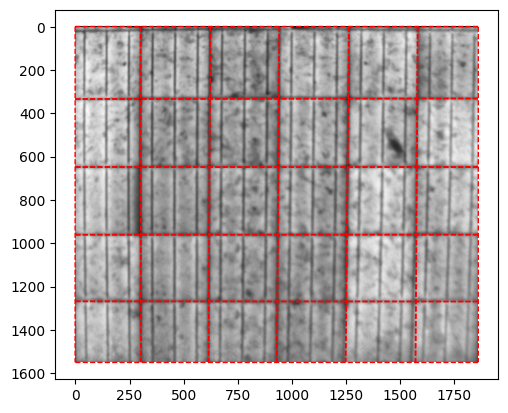

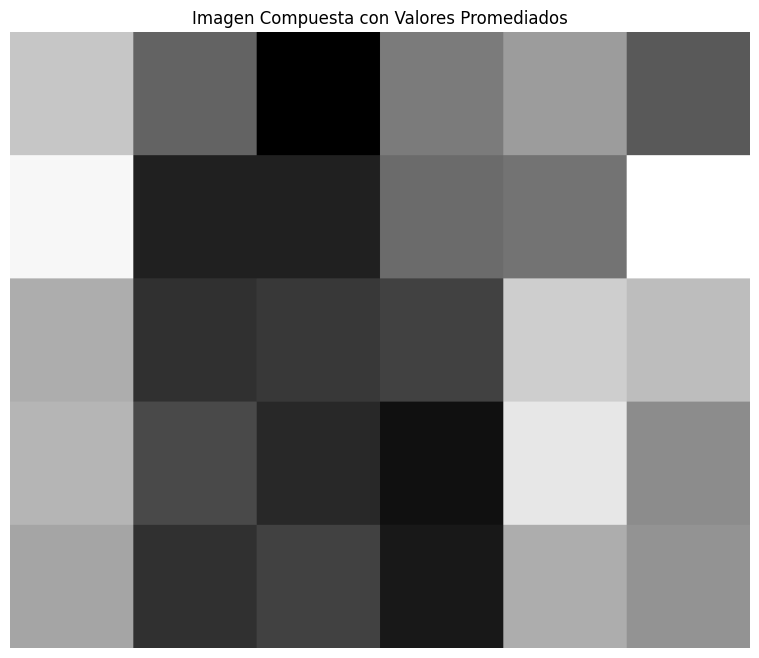

In [14]:
# Recorte de celdas
single_cells = raw_module.crop_cell(cellsize=155, plot=True)

# Obtén el tamaño de la celda
cell_height, cell_width = single_cells[0].shape

# Ajusta el tamaño de la nueva imagen compuesta para que sea un múltiplo exacto del tamaño de las celdas
total_height = cell_height * 5  # 5 filas
total_width = cell_width * 6  # 6 columnas
new_image = np.zeros((total_height, total_width), dtype=img.dtype)

# Recorre cada celda recortada, promedia los valores de los píxeles, y coloca en la nueva imagen
for i, cell in enumerate(single_cells):
    # Promedia el valor de los píxeles en la celda
    mean_value = np.mean(cell)
    
    # Crea una celda con el valor promedio
    mean_cell = np.full_like(cell, mean_value)
    
    # Calcula la posición en la nueva imagen
    row = i // 6  # 6 columnas
    col = i % 6
    start_y = row * cell_height
    start_x = col * cell_width
    
    # Coloca la celda promediada en la posición correspondiente
    new_image[start_y:start_y + cell_height, start_x:start_x + cell_width] = mean_cell

# Muestra la nueva imagen compuesta
plt.figure(figsize=(10, 8))
plt.imshow(new_image, cmap='gray')
plt.title('Imagen Compuesta con Valores Promediados')
plt.axis('off')
plt.show()

In [15]:
# Guarda la imagen compuesta
save_path = Path(save_path)
save_path.mkdir(parents=True, exist_ok=True)
save_name = save_path / f'{module_name}.jpg'
cv.imwrite(str(save_name), new_image)
print(f'Imagen compuesta guardada en {save_name}')

Imagen compuesta guardada en D:\Documentos\Universidad de Cuenca\Trabajo de Titulación\Datasets_EL\ModulosPID\poli2_inf_PID.jpg
